# Evaluation

The `Evaluation` class is the actual interface for the user with the
functionalities of the `pyEvalData` package. It provides access to the raw
data via the `Source` object, given on initialization.  
The main features of the `Evaluation` class are the definition of counter
aliases as well as new counters by simple algebraic expressions.
At the same time pre- and post-filters can be applied to the raw and
evaluated data, respectively.
Much efforts have been put into the binning, averaging, and error calculation
of the raw data.
In addition to the evaluation of a list of scans or scan sequence of one or
multiple scans in dependence of an external paramter, the `Evaluation` class
also provides high-level helper functions for plotting and fitting the
according results.

## Setup

Here we do the necessary import for this example

In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import pyEvalData as ped
# import lmfit for fitting
import lmfit as lf
# import some usefull fit functions
import ultrafastFitFunctions as ufff
# define the path for the example data
example_data_path = '../../../example_data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Source

Here we iitialize the `Source` for the current evaluation. It is based on raw
data in a [SPEC file](https://certif.com/content/spec) which was generated by
the open-source software [Sardana](https://sardana-controls.org).

In [19]:
spec = ped.io.Spec(file_name='example_file_spec2.spec',
                   file_path=example_data_path,
                   use_nexus=True,
                   force_overwrite=False,
                   update_before_read=False,
                   read_and_forget=True)

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_raw
pyEvalData.io.source - INFO: Create spec_file from xrayutilities
pyEvalData.io.source - INFO: save_all_scans_to_nexus
pyEvalData.io.source - INFO: read_raw_scan_data for scan #1
pyEvalData.io.source - INFO: save_scan_to_nexus for scan #1
pyEvalData.io.source - INFO: read_raw_scan_data for scan #2
pyEvalData.io.source - INFO: save_scan_to_nexus for scan #2
pyEvalData.io.source - INFO: read_raw_scan_data for scan #3
pyEvalData.io.source - INFO: save_scan_to_nexus for scan #3
pyEvalData.io.source - INFO: read_raw_scan_data for scan #4
pyEvalData.io.source - INFO: save_scan_to_nexus for scan #4
pyEvalData.io.source - INFO: read_raw_scan_data for scan #5
pyEvalData.io.source - INFO: save_scan_to_nexus for scan #5
pyEvalData.io.source - INFO: read_raw_scan_data for scan #6
pyEvalData.io.source - INFO: save_scan_to_nexus for scan #6


### Initialization of `Evaluation` object

For the most basic example we just have to provide a `Source` on initialization: 

In [20]:
ev = ped.Evaluation(spec)

Now it is possible to check the available attributes of the `Evaluation`
object, which will be explained step-by-step in the upcominng sections.

In [21]:
print(ev.__doc__)

Evaluation

    Main class for evaluating data.
    The raw data is accessed via a ``Source`` object.
    The evaluation allows to bin data, calculate errors and propagate them.
    There is also an interface to ``lmfit`` for easy batch-fitting.

    Args:
        source (Source): raw data source.

    Attributes:
        log (logging.logger): logger instance from logging.
        clist (list[str]): list of counter names to evaluate.
        cdef (dict{str:str}): dict of predefined counter names and
            definitions.
        xcol (str): counter or motor for x-axis.
        t0 (float): approx. time zero for delay scans to determine the
            unpumped region of the data for normalization.
        custom_counters (list[str]): list of custom counters - default is []
        math_keys (list[str]): list of keywords which are evaluated as numpy functions
        statistic_type (str): 'gauss' for normal averaging, 'poisson' for counting statistics
        propagate_errors (bool): 

### Simple plot example

To plot data, the `Evlauation` objects does only need to know the `xcol` as
horizontal axis as well a list of *counters* to plot, which is called `clist`.

First we can check the available scan numbers in the source:

In [22]:
spec.get_all_scan_numbers()

[1, 2, 3, 4, 5, 6]

Now we can check for the available data for a specific scan

In [23]:
spec.scan1.data.dtype.names

('Diff',
 'DiffM',
 'Pt_No',
 'Pumped',
 'PumpedErr',
 'PumpedErrM',
 'PumpedM',
 'Rel',
 'RelM',
 'Unpumped',
 'UnpumpedErr',
 'UnpumpedErrM',
 'UnpumpedM',
 'chirp',
 'delay',
 'dt',
 'duration',
 'durationM',
 'envHumid',
 'envTemp',
 'freqTriggers',
 'magneticfield',
 'numTriggers',
 'numTriggersM',
 'thorlabsPM',
 'thorlabsPPM',
 'thorlabsPPMonitor')

So let's try to plot the counters `Pumped` and `Unpumped` vs the motor `delay`: 

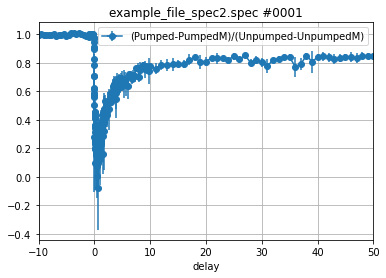

In [37]:
ev.xcol = 'delay'
ev.clist = ['(Pumped-PumpedM)/(Unpumped-UnpumpedM)']
ev.propagate_errors = False

plt.figure()
ev.plot_scans([1, 2, 3, 4])
plt.xlim(-10, 50)
plt.show()

Next we want to plot the relative signal of the two former counter

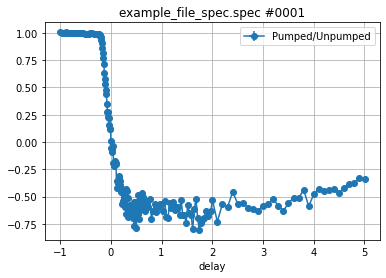

In [18]:
ev.xcol = 'delay'
ev.clist = ['Pumped/Unpumped']
ev.propagate_errors=True

plt.figure()
ev.plot_scans([1])
plt.show()

In [33]:
print(ev.add_custom_counters.__doc__)

Add custom counters to the spec data array.
        This is a stub for child classes.

        Args:
            spec_data (ndarray) : Data array from the spec scan.
            scan_num (int)  : Scan number of the spec scan.
            source_counters list(str) : List of the source counters and custom counters
                                     from the clist and xcol.

        Returns:
            spec_data (ndarray): Updated data array from the spec scan.

        


It is also possible to access the scan directly as attribute of the source which is fully aquivalent to the last example

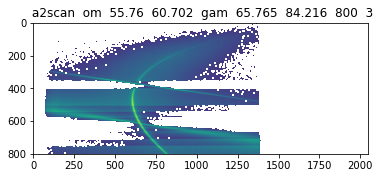

In [5]:
plt.figure()
plt.imshow(np.log10(spec.scan33.MCA))
plt.title(spec.scan33.cmd)
plt.show()

## Sardana NeXus

The [NeXus fiel format](https://www.nexusformat.org) is a common standard in science for storing and exchanging data.
It is based on `hdf5` files with a hierarchical desgin. As an example we read the NeXus files as created by Sardana.
As we can directly access the data from the NeXus files, there is no need to enable additional NeXus export so one can set `source.use_nexus = False`.

In [6]:
sarnxs = ped.io.SardanaNeXus(file_name='sardana_nexus.h5',
                             file_path='data/',
                             use_nexus=False,
                             force_overwrite=False,
                             update_before_read=False,
                             read_and_forget=True)

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_raw


pyEvalData.io.source - INFO: read_raw_scan_data for scan #435


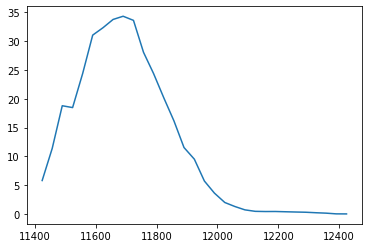

In [7]:
plt.figure()
plt.plot(sarnxs.scan435.mhor, sarnxs.scan435.pmPump)
plt.show()

## PAL FEL

In [8]:
pal = ped.io.PalH5(name='2020_12_Schick',
                   file_name='{0:07d}',
                   file_path='./data/pal_fel',
                   use_nexus=False,
                   force_overwrite=False,
                   update_before_read=True,
                   read_and_forget=True,
                   nexus_file_path='./',
                   nexus_file_name='2020_12_Schick')

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_raw


In [9]:
s = ped.Evaluation(pal)

In [10]:
cdef = {
             'apd1'        : 'digi1_2',
             'apd2'        : 'digi1_1', 
             'apd3'        : 'digi1_3',
             'mcp'         : 'digi1_0', 
             'frontPD'     : 'digi2_0',
             'rearPD'      : 'digi2_1',
             'chn'         : 'digi2_2',
             'laserPD'     : 'digi2_3',
            }
statistic_type = 'gaussian'
propagate_errors = False
math_keys = ['mean', 'sum', 'diff', 'max', 'min', 'round', 'abs',
            'sin', 'cos', 'tan', 'arcsin', 'arccos', 'arctan',
            'pi', 'exp', 'log', 'log10', 'sqrt', 'mod', 'int32', 'std']

In [11]:
s.cdef = cdef
s.math_keys = math_keys
s.statistic_type = statistic_type
s.propagate_errors = propagate_errors

pyEvalData.io.source - INFO: read_raw_scan_data for scan #9


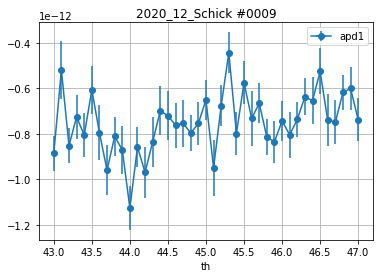

In [12]:
plt.figure()
s.xcol = 'th'
s.clist = ['apd1']

s.plot_scans([9], xgrid=np.r_[-1000:1000:0.0001], yerr='err')

plt.show()

## Composite Sources

On specific idea of the `Source` class is to provide also composite models of pre-defined `Source` classes.
An example is the `Spec` source for reading SPEC data files and a `Source` class to read camera images from a folder structure, that have been acquired simultaneously with the SPEC file.
This would require to specify the two independent `Souce` objects and then add them to a single `CompositeSource`:
```python
spec = ed.io.Spec(file_name, file_path)
ccd = ed.io.Pilatus(image_pattern, image_base_path)

comp_source = spec + ccd
```